## Value factors

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import yaml
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
import seaborn as sns

load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
psql = create_engine(db_url)

We aim to recreate a value signal that would be used at quant factor funds like AQR. Value factors are sensitive to industry-specific 
valuations; an example of this would be that banks are likely to have softer valuation multiples than tech companies.

> Before beginning calculations, we winsorize any value factors between 1st and 99th percentiles to deal with any extreme values, and take care of data issues that may have not be pre-handled.

Given a value factor $V$, and $s$ industries $I = \{I_1, I_2, \dots, I_s \}$ and $n$ stocks $S = \{S_1, S_2, \dots, S_n \}$, the value factor for a stock $i$ in industry $j$ on day (close) $t$ is notated by $V_{ijt}$. We then have the cross-sectional, industry-neutralised score on close $t$ for stock $i$ as
$$ \tilde{V}_{sit} = \frac{V_{sit} - \mu_{it}}{\sigma_{it}}$$

where

$$ \mu_{it} = \frac{1}{||I_i||}\sum_{S \in \text{industry }i} V_{Sit}$$

and the cross-sectional, sample deviation for $\sigma_{it}$, similar to the sample mean above.

Finally, we have the *composite* score which is the re-centred across the entire universe, given by the z-score function $Z(x)$ as 

$$ \bar{V}_{sit} = Z(\tilde{V}_{sit})$$

#### An example with `P/E`

We pull `P/E` factors for our observable `S&P 500` universe.

In [50]:
adjusted_monthly = pd.read_sql("""
    select
        *
    from
        adjusted_monthly
    """,
    psql
)

adjusted_monthly['adj_return'] = np.log(adjusted_monthly['adj_close'] / adjusted_monthly['adj_close'].shift())
adjusted_monthly['adj_return_fwd'] = adjusted_monthly['adj_return'].shift(-1)
adjusted_monthly = adjusted_monthly.dropna()

In [4]:
tickers = adjusted_monthly['ticker'].unique().tolist()
sql_tickers = ", ".join(f"'{v}'" for v in tickers)

value_factors = pd.read_sql("select metric from factor_styles where style = 'VALUE'", psql)['metric'].to_list()
sql_value_factors = ", ".join(f"'{v}'" for v in value_factors)

In [5]:
value_factor_data = pd.read_sql(
    f"""
    select
        *
    from
        fundamentals_monthly
    where
        ticker in ({sql_tickers})
    and
        metric in ({sql_value_factors})    
    """,
    psql
)

In [27]:
constituents = pd.read_sql(
    """
    select
        ticker, start_date, end_date, sector
    from
        constituents
    """,
    psql
).dropna(subset=['sector'])

constituents['start_date'] = pd.to_datetime(constituents['start_date'])

# keep the row with the latest start_date for each ticker
constituents_latest = (
    constituents
    .sort_values(['ticker', 'start_date'], ascending=[True, False])
    .drop_duplicates(subset='ticker', keep='first')
    .reset_index(drop=True)
)

constituents_latest = constituents[['ticker', 'sector']]

The following is the steps for each factor, to create sector-neutral `z`-scores.

For each day:
1. Winsorise the values cross-sectionally
2. Create sector-neutral z-scores for each stock
3. Create universe-wide z-scores

In [ ]:
value_and_const = value_factor_data.merge(
    constituents_latest,
    on='ticker'
)

In [32]:
pe = value_and_const[value_and_const['metric'] == 'price_earnings']

In [44]:
from scipy.stats import zscore

pe_results = []

for date, data in pe.groupby('date'):
    for sector, sdata in data.groupby('sector'):
        sdata_copy = sdata.copy()
        sdata_copy['value'] = winsorize(sdata_copy['value'], limits=(0.01, 0.01))
        sdata_copy['metric_sector_zscore'] = zscore(sdata_copy['value'])
        
        pe_results.append(sdata_copy[['date', 'ticker', 'metric_sector_zscore']])

pe_df = pd.concat(pe_results).reset_index(drop=True)

In [53]:
return_and_pe = adjusted_monthly.merge(pe_df, on=['ticker', 'date'])

In [75]:
pe_ic = []

for date, data in return_and_pe.groupby('date'):
    pe_ic.append({
        'date': date,
        'ic': data['adj_return_fwd'].corr(-data['metric_sector_zscore'], method = 'spearman')
    })

pe_ic = pd.DataFrame(pe_ic)

In [134]:
pe_ic['rolling_ic'] = pe_ic['ic'].rolling(window=12 * 5).mean()
pe_ic = pe_ic.dropna()

Now let us consider the results for `P/E` for the sector-neutralised results.

Text(0.5, 1.0, 'Waning strength for P/E value factor')

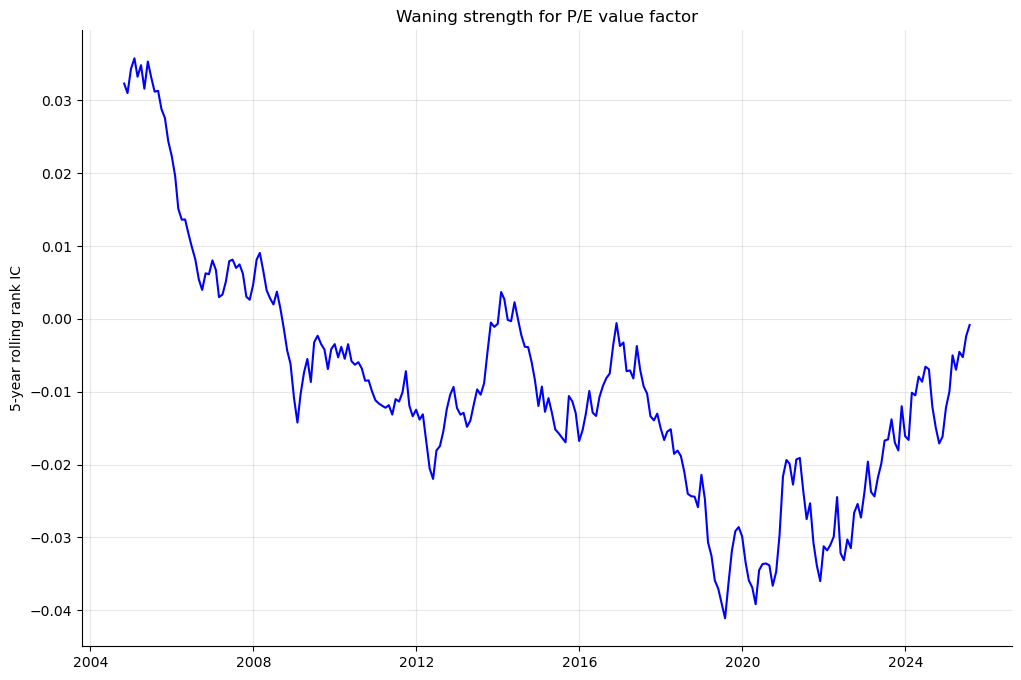

In [137]:
plt.figure(figsize=(12, 8))
plt.plot(pe_ic['date'], pe_ic['rolling_ic'], color='blue')
sns.despine()
plt.ylabel('5-year rolling rank IC')
plt.grid(alpha=0.3)
plt.title('Waning strength for P/E value factor')

### Using all of the factors

An important step here is to consider which factors indicate a cheap valuation when they are `< 0` z-score and otherwise

In [93]:
factor_results = []

flip_metrics = {'ev_ebit', 'ev_ebitda', 'price_book', 'price_earnings', 'price_sales'}

for date, data in value_and_const.groupby('date'):
    for sector, sdata in data.groupby('sector'):
        for factor, fdata in sdata.groupby('metric'):
            fdata_copy = fdata.copy()
            fdata_copy['value'] = winsorize(fdata_copy['value'], limits=(0.01, 0.01))
            fdata_copy['value_zscore'] = zscore(fdata_copy['value'])

            if factor in flip_metrics:
                fdata_copy['value_zscore'] *= -1

            factor_results.append(fdata_copy[['date', 'ticker', 'metric', 'value_zscore']])

factor_df = pd.concat(factor_results)        

We first consider the predictive ability for each factor before creating the composite factor score.

In [ ]:
returns_and_factors = adjusted_monthly.merge(
    factor_df,
    how = 'left',
    on = ['date', 'ticker']
)

In [96]:
returns_and_factors

,date,adj_close,volume,ticker,adj_return,adj_return_fwd,metric,value_zscore
0,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,book_to_market,-0.194481
1,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,earnings_price,0.147796
2,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,ebit_ev,0.092194
3,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,ebitda_ev,0.169691
4,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,ev_ebit,-0.406942
...,...,...,...,...,...,...,...,...
1202775,2025-06-30,155.4303,2826600.0,ZTS,-0.078171,-0.044939,ev_ebitda,-0.153727
1202776,2025-06-30,155.4303,2826600.0,ZTS,-0.078171,-0.044939,price_book,-0.280273
1202777,2025-06-30,155.4303,2826600.0,ZTS,-0.078171,-0.044939,price_earnings,-0.017551
1202778,2025-06-30,155.4303,2826600.0,ZTS,-0.078171,-0.044939,price_sales,-0.991337


In [98]:
factor_ics = []

for date, data in returns_and_factors.groupby('date'):
    for factor, fdata in data.groupby('metric'):
        factor_ics.append({
            'date': date,
            'factor': factor,
            'ic': fdata['adj_return_fwd'].corr(fdata['value_zscore'], method='spearman')
        })

factor_ic_df = pd.DataFrame(factor_ics)

Text(0, 0.5, 'Rank IC')

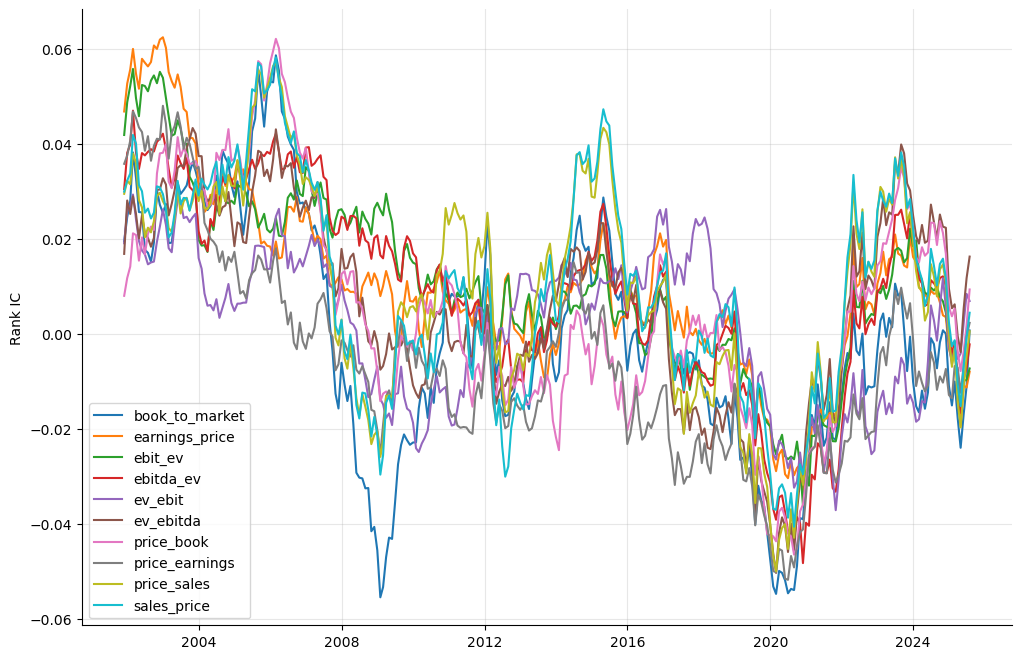

In [ ]:
factor_ic_df = factor_ic_df.sort_values(['factor', 'date'])
factor_ic_df['rolling_ic'] = (
    factor_ic_df
    .groupby('factor')['ic']
    .rolling(window=36)
    .mean()
    .reset_index(level=0, drop=True)
)
factor_ic_df = factor_ic_df.dropna()

plt.figure(figsize=(12, 8))
for f, fdata in factor_ic_df.groupby('factor'):
    plt.plot(fdata['date'], fdata['rolling_ic'], label=f)

plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.ylabel('Rank IC')
plt.title('The predictive rank IC of all of our factors')

We can observe that many of our factors are highy correlated, and that since 2000, the predictive power of these factors has appeared to decay. This is not surprsing, as markets becoming increasingly efficient and less reliant of 'valuation' as before.

#### The composite score

We now consider the composite scores results for the value factor.

In [112]:
factor_composite = (
    factor_df
    .groupby(['date','ticker'])['value_zscore']
    .mean()
    .reset_index(name='value_comp')
)

In [120]:
returns_and_composite = adjusted_monthly.merge(
    factor_composite,
    how = 'left',
    on = ['date', 'ticker']
).dropna()

In [121]:
composite_ic = []

for date, data in returns_and_composite.groupby('date'):
    composite_ic.append({
        'date': date,
        'ic': data['adj_return_fwd'].corr(data['value_comp'], method='spearman')
    })

composite_ic_df = pd.DataFrame(composite_ic)

Text(0, 0.5, '5-year rolling IC')

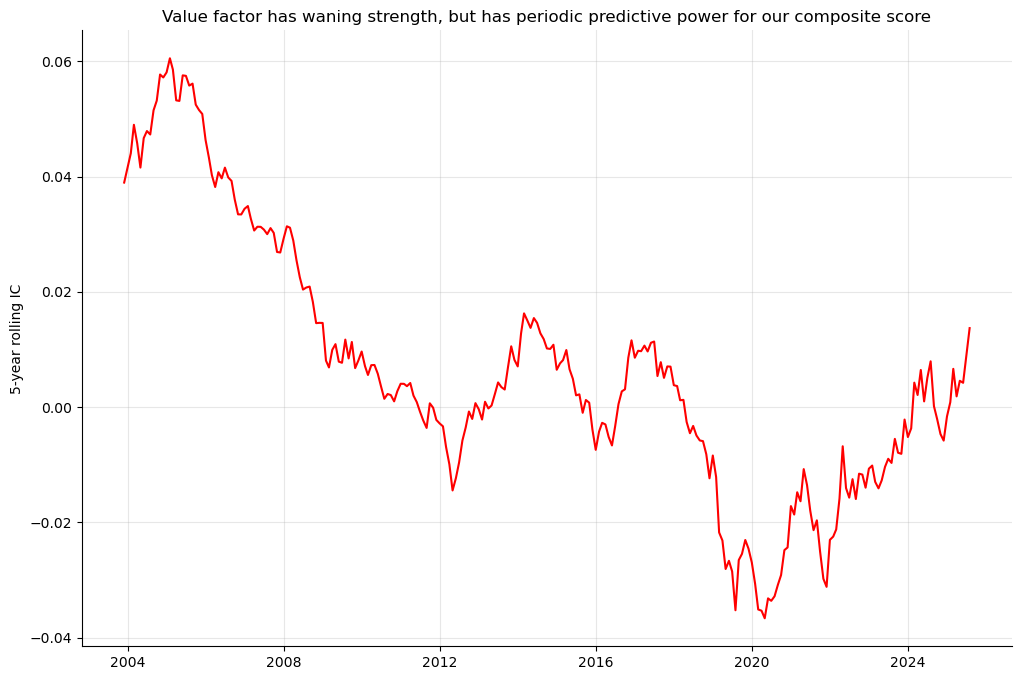

In [132]:
composite_ic_df['rolling_ic'] = composite_ic_df['ic'].rolling(window=12*5).mean()

plt.figure(figsize=(12, 8))
plt.plot(composite_ic_df['date'], composite_ic_df['rolling_ic'], color='red')
sns.despine()
plt.grid(alpha=0.3)
plt.title('Value factor has waning strength, but has periodic predictive power for our composite score')
plt.ylabel('5-year rolling IC')